In [1]:
from netgan.netgan import *
import tensorflow as tf
from netgan import utils
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time

%matplotlib inline

/home/rodrigo/anaconda3/envs/netgan/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


#### Load the data

In [24]:
_A_obs, _X_obs, _z_obs = utils.load_npz('data/cora_ml.npz')
print(_A_obs.shape)
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]
print(_N)

(2995, 2995)
Selecting 1 largest connected components
2810


In [3]:
val_share = 0.1
test_share = 0.05
seed = 481516234

#### Load the train, validation, test split from file

In [4]:
loader = np.load('pretrained/cora_ml/split.npy', allow_pickle=True).item()

In [5]:
train_ones = loader['train_ones']
val_ones = loader['val_ones']
val_zeros = loader['val_zeros']
test_ones = loader['test_ones']
test_zeros = loader['test_zeros']

In [6]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Parameters

In [7]:
rw_len = 16
batch_size = 128

In [8]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

#### Create our NetGAN model

In [9]:
netgan = NetGAN(_N, rw_len, walk_generator= walker.walk, gpu_id=3, use_gumbel=True, disc_iters=3,
                W_down_discriminator_size=32, W_down_generator_size=128,
                l2_penalty_generator=1e-7, l2_penalty_discriminator=5e-5,
                generator_layers=[40], discriminator_layers=[30], temp_start=5, temperature_decay=0.99998, learning_rate=0.0003, legacy_generator=True)

#### Load pretrained model

In [10]:
saver = tf.train.Saver()
saver.restore(netgan.session, "pretrained/cora_ml/pretrained_gen.ckpt")

INFO:tensorflow:Restoring parameters from pretrained/cora_ml/pretrained_gen.ckpt


#### Generate random walks on the trained model

In [11]:
sample_many = netgan.generate_discrete(10000, reuse=True, legacy=True)

In [12]:
samples = []

In [13]:
for _ in range(60):
    if (_+1) % 500 == 0:
        print(_+1)
    samples.append(sample_many.eval({netgan.tau: 0.5}))

#### Assemble score matrix from the random walks

In [14]:
rws = np.array(samples).reshape([-1, rw_len])
scores_matrix = utils.score_matrix_from_random_walks(rws, _N).tocsr()

#### Compute graph statistics

In [15]:
A_select = sp.csr_matrix((np.ones(len(train_ones)), (train_ones[:,0], train_ones[:,1])))

In [16]:
A_select = train_graph

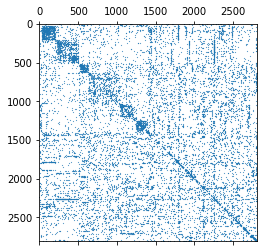

In [17]:
sampled_graph = utils.graph_from_scores(scores_matrix, A_select.sum())
plt.spy(sampled_graph, markersize=.2)
plt.show()

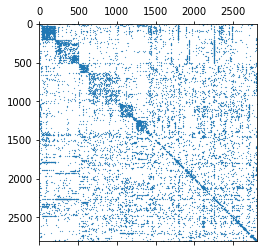

In [18]:
plt.spy(A_select, markersize=.2)
plt.show()

In [19]:
utils.edge_overlap(A_select.toarray(), sampled_graph)/(A_select.sum() + sampled_graph.sum() - utils.edge_overlap(A_select.toarray(), sampled_graph))

0.34690230341540906

In [22]:
sampled_graph.sum()/2

6783.0

In [20]:
utils.compute_graph_statistics(sampled_graph)

{'d_max': 208.0,
 'd_min': 1.0,
 'd': 4.8277580071174375,
 'LCC': 2808,
 'wedge_count': 81711.0,
 'claw_count': 2012986.9999999998,
 'triangle_count': 1593,
 'square_count': 100,
 'power_law_exp': 1.7895083284905389,
 'gini': 0.41927374433571907,
 'rel_edge_distr_entropy': 0.9545167096100138,
 'assortativity': -0.06999697303781284,
 'clustering_coefficient': 0.0023740838862844125,
 'n_components': 2,
 'cpl': 5.18205448374016}

In [21]:
utils.compute_graph_statistics(A_select.toarray())

/home/zuegnerd/anaconda3/envs/tf/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


{'d_max': 240.0,
 'd_min': 1.0,
 'd': 4.8277580071174375,
 'LCC': 2810,
 'wedge_count': 101872.0,
 'claw_count': 3094240.0,
 'triangle_count': 2814,
 'square_count': 517,
 'power_law_exp': 1.85595899191131,
 'gini': 0.48239580529720794,
 'rel_edge_distr_entropy': 0.9407067745192429,
 'assortativity': -0.07543032480414193,
 'clustering_coefficient': 0.0027282951548684006,
 'n_components': 1}